# Práctico: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
#This file contains information about music artists listened and tagged by the users.
artist_data = pd.read_csv("../data/lastfm/artists.dat", sep="\t")

#This file contains the set of tags available in the dataset (ojo con el enconding en este!)
user_tags = pd.read_csv("../data/lastfm/tags.dat", sep="\t", encoding='latin-1')

#This file contains the artists listened by each user.
#It also provides a listening count for each [user, artist] pair.
user_artists_plays = pd.read_csv("../data/lastfm/user_artists.dat", sep="\t")

#These files contain the tag assignments of artists provided by each particular user. 
#They also contain the timestamps when the tag assignments were done.
user_tag_artists = pd.read_csv("../data/lastfm/user_taggedartists.dat", sep="\t")
user_tag_artists_time = pd.read_csv("../data/lastfm/user_taggedartists-timestamps.dat", sep="\t")

#These files contain the friend relations between users in the database.
user_friends = pd.read_csv("../data/lastfm/user_friends.dat", sep="\t")

In [3]:
#artist_data.info()
user_tags.info()
#user_artist_plays.info()
#user_tag_artists.info()
#user_friends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tagID     11946 non-null  int64 
 1   tagValue  11946 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB


## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [4]:
user_artists_plays[user_artists_plays['artistID']==1]

,userID,artistID,weight
1550,34,1,212
12611,274,1,483
35861,785,1,76


#### Artistas más escuchados

Vamos a crear una variable nueva **user_count** que nos dice cuántos usuarios escucharon a cada artista.  
La variable **weight** se le asigna a cada artista y es la sumatoria de todas las escuchas de un conjunto de usuarios
para cada artista.  
Luego crearemos dos variables más a partir de las dos anteriores: **count_range** **weight_range**. Estas variables agrupan 
en 4 grupos cada una a cada artista en función de **user_ count** y **weight**, y nos permiten visualizar cómo se distribuye los diversos valores en el conjunto de información 


In [5]:
escuchas_artistas = user_artists_plays['artistID'].value_counts()
df_val_counts = pd.DataFrame(escuchas_artistas).sort_index().rename(columns={'artistID': 'value_counts'})
user_artist_plays_sorted = user_artists_plays.groupby(['artistID']).sum()
user_artist_plays_sorted['user_count'] = df_val_counts['value_counts']
user_artist_plays_sorted.reset_index(inplace=True)
#armamos un dataset con el feature nuevo user_count
df_user_artist_plays = user_artist_plays_sorted.drop(['userID'], axis=1)
#agregamos bins sobre el feature user_count
df_user_artist_plays['count_range'] = pd.cut(df_user_artist_plays['user_count'], [0, 50, 100,200,700])
df_user_artist_plays['weight_range'] = pd.cut(df_user_artist_plays['weight'], [0, 50, 1000,10000,3000000])
df_user_artist_plays.head()


,artistID,weight,user_count,count_range,weight_range
0,1,771,3,"(0, 50]","(50, 1000]"
1,2,8012,12,"(0, 50]","(1000, 10000]"
2,3,775,3,"(0, 50]","(50, 1000]"
3,4,563,2,"(0, 50]","(50, 1000]"
4,5,913,2,"(0, 50]","(50, 1000]"


<AxesSubplot:xlabel='count', ylabel='weight_range'>

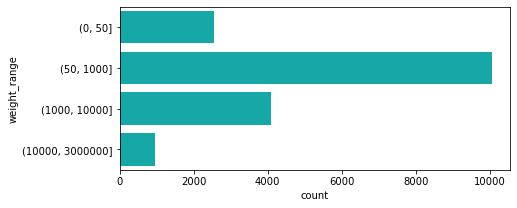

In [6]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='weight_range', data=df_user_artist_plays, color="c")

<AxesSubplot:xlabel='count', ylabel='count_range'>

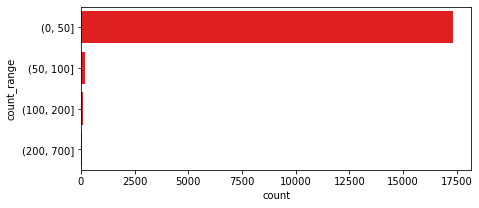

In [7]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='count_range', data=df_user_artist_plays, color="r")

Hay dos **datos interesantes** que obtenemos a partir de estos gráficos:  
a. la mayor masa de peso (**weitght_range**) asociado a artistas se concentra entre los 50 y los 1000 puntos;  
b. la mayor parte de los artistas (**count_range**) es escuchado por menos de 50 usuarios (de hecho, la mayoría solo es escuchado por 1 usuario);  

A continuación analizamos los artistas más escuchados utilizando dos variables: **weight** y **user_count**

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Lady Gaga'),
  Text(1, 0, 'Britney Spears'),
  Text(2, 0, 'Rihanna'),
  Text(3, 0, 'The Beatles'),
  Text(4, 0, 'Katy Perry')])

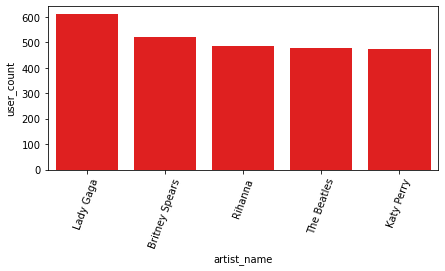

In [8]:
df_user_artist_plays['artist_name'] = artist_data['name']
most_play_artist_user= df_user_artist_plays.sort_values(by=['user_count'], ascending=False)

f, ax = plt.subplots(figsize=(7, 3))
sns.barplot(x="artist_name", y="user_count", data=most_play_artist_user.iloc[0:5, :],
            label="Total", color="r")
plt.xticks(rotation=70)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Britney Spears'),
  Text(1, 0, 'Depeche Mode'),
  Text(2, 0, 'Lady Gaga'),
  Text(3, 0, 'Christina Aguilera'),
  Text(4, 0, 'Paramore')])

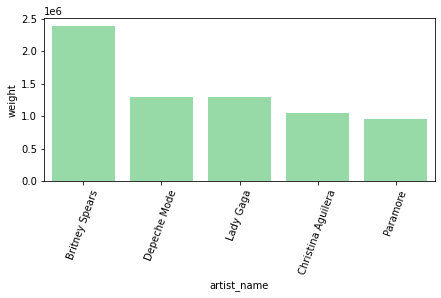

In [9]:
most_play_artist_weight= df_user_artist_plays.sort_values(by=['weight'], ascending=False)
f, ax = plt.subplots(figsize=(7, 3))
sns.set_color_codes('pastel')
sns.barplot(x="artist_name", y="weight", data=most_play_artist_weight.iloc[0:5, :],
            label="Total", color="g")
plt.xticks(rotation=70)

A partir de los últimos gráficos podemos decir que en este punto es determinante qué variable vamos a considerar para elegir a los artístas más escuchados, dado que, como vemos, aquellos que tienen mayor cantidad de usuarios no coinciden con aquellos que poseen más peso en las escuchas de usuarios en la global.

#### Distribución de cantidad de listens por usuarios

Filtramos el dataset con la información de cada usuario y la cantidad de listens (nos quedamos con las variables **userID** y **weight**). Lo que queremos ver es la distribución de la cantidad total de listens por usuarios en el dataset.

In [10]:
df_listens_per_users = user_artists_plays.drop(['artistID'], axis=1)
df_listens_per_users = df_listens_per_users.groupby(['userID']).sum().reset_index()
df_listens_per_users.sort_values(by=['weight'], ascending=False).head()

,userID,weight
705,757,480039
1802,2000,468409
1280,1418,416349
1482,1642,388251
1002,1094,379125


/home/adrian/anaconda3/envs/rec-sys/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='weight'>

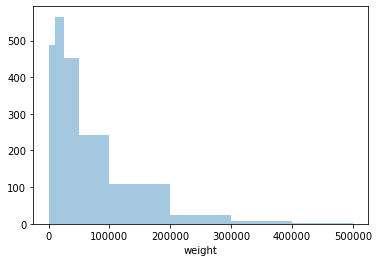

In [11]:
bins_list = [0, 10000, 25000, 50000, 100000, 200000, 300000, 400000, 500000]
sns.distplot(df_listens_per_users['weight'], bins=bins_list, kde=False)

El gráfico muestra que claramente la mayor parte de la masa de instancias de listens se congrega en entre en el intervalo que va de 0 a 25000. Esto lo podemos analizar con los siguientes estadísticos.

In [12]:
df_listens_per_users['weight'].describe()

count      1892.000000
mean      36566.582981
std       48744.552394
min           3.000000
25%        9742.250000
50%       21573.000000
75%       42963.750000
max      480039.000000
Name: weight, dtype: float64

Si bien el 75% de las instancias se encuentran debajo de los 43000 listens, aun así el promedio se ubica en 36000. Esto se debe a la cantidad de listens que aglomeran el 25% de las intancias con los valores más altos, algo que no debemos ignorar. Si fueran outliers podríamos simplemente limpiarlos o procesarlos de alguna forma, pero cabe preguntarse si ese mismo tratamiento puede realizarse sin más en este dataset.

#### Géneros musicales más escuchados

¿Podemos obtener de la información en los datasets los géneros más escuchados? Poseemos un conjunto de datos donde los usuarios han etiquetado los estilos asociados a cada artista (**user_tag_artists**). Asumimos que han escuchado a estos artistas.  
La pregunta es ¿cómo usamos estas etiquetas? Hay dos posibilidades: o bien realizamos un conteo de aquellas etiquetas que aparecen más (esto sería asumir una relación lineal entre cantidad de tags igual a cantidad de escuchas) o podríamos hacer un esfuerzo en cruzar los tags más comúnes con los artistas más escuchados. La idea es que si encontramos cómo se distribuyen lso géneros en los artistas con mayor masa de escuchas, tenemos una buena idea de cuáles son los géneros más escuchados.  
Asignamos a una nueva variable **df_tags** el dataset **user_tag_artists** con la variable agregada **tagValue** para saber cuál es el estilo en cuestión. Luego asignamos a la variable  **df_tags_counts** un dataset con el conteo de tags.

In [13]:
df_tags = pd.merge(user_tag_artists, user_tags, how='left', on=['tagID', 'tagID'])
df_tags.head()

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,52,15,1,4,2009,downtempo
2,2,52,18,1,4,2009,electronic
3,2,52,21,1,4,2009,trip-hop
4,2,52,41,1,4,2009,female vovalists


In [14]:
tag_counts = user_tag_artists['tagID'].value_counts()
df_tags_counts = pd.DataFrame(tag_counts).sort_index().rename(columns={'tagID': 'tag_counts'})
df_tags_counts = df_tags_counts.reset_index().rename(columns={'index': 'tagID'})
df_tags_counts = pd.merge(df_tags_counts, user_tags,how='left', on=['tagID', 'tagID'] ).sort_values(by=['tag_counts'], ascending=False) 
df_tags_counts.head()

,tagID,tag_counts,tagValue
71,73,7503,rock
23,24,5418,pop
77,79,5251,alternative
17,18,4672,electronic
79,81,4458,indie


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'rock'),
  Text(1, 0, 'pop'),
  Text(2, 0, 'alternative'),
  Text(3, 0, 'electronic'),
  Text(4, 0, 'indie'),
  Text(5, 0, 'female vocalists'),
  Text(6, 0, '80s'),
  Text(7, 0, 'dance'),
  Text(8, 0, 'alternative rock'),
  Text(9, 0, 'classic rock')])

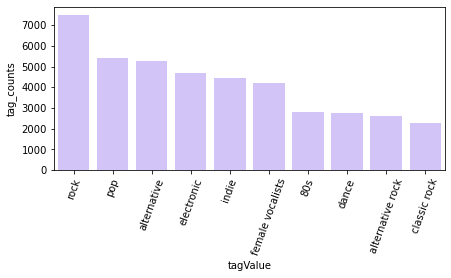

In [15]:
f, ax = plt.subplots(figsize=(7, 3))
sns.set_color_codes('pastel')
sns.barplot(x="tagValue", y="tag_counts", data=df_tags_counts.iloc[0:10, :],
            label="Total", color="m")
plt.xticks(rotation=70)

En el gráfico podemos observar los 10 tags de géneros musicales más utilizados o "marcados" por usuarios.  
¿Es esto realmente representativo de los géneros más escuchados?
Podría ser el caso que un solo usuario hubiera tageado a una gran cantidad de artistas con un género de manera deliberada y malintencionada.  
Supongamos que 100 usuarios se hubieran puesto en campaña de taggear a todo lo que se les cruzara como "alternative". Le tomaría etiquetar a 100 artistas distintos cada uno para generar una muestra de 10000 tags! Este sería un escenario en el que menos del 7% de los usuarios que tagearan a menos de 7% de los artistas lograrían sesgar nuestra percepción acerca del género más escuchado.

## Ejercicio 2 - Sistema de Recomendación

### Ejercicio 2a - Filtrados Colaborativos

Deberán realizar un sistema de filtrados colaborativos basado en [Surpr!se](http://surpriselib.com/), a partir de los datos que proporciona `LastFM`, en especial el archivo `user_artists.dat`. Tener en cuenta los siguientes pasos:

1. **Desarrollo de la matriz de Usuario-Contenido:** A partir del conjunto de datos deberán generar una matriz de usuario-contenido. Tener en cuenta que los ratings son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a determinado artista.
2. **Entrenamiento del algoritmo de recomendación**: Utilizando las herramientas brindadas por [Surpr!se](http://surpriselib.com/), entrenen varios modelos (al menos 3) de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo. Si necesitan inspiración, les recomendamos revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).
3. **Sistema de recomendación**: A partir del mejor modelo de recomendación que haya surgido del caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares. La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

### 1. Desarrollo de la matriz de usuario-contenido

In [16]:
# We need a dataframe with userId, artistId and rating (given as listening quantity)
# This file contains the artists listened by each user.
# It also provides a listening count for each [user, artist] pair.
userContentMatrix = pd.read_csv("../data/lastfm/user_artists.dat", sep="\t")
userContentMatrix.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [17]:
# Normalice weigth in range from 0 to 10

# We use max weight assigned by an user to an artist to divide current weigth
maxUserWeightDict = dict(userContentMatrix.groupby('userID')['weight'].max())
userContentMatrix["weight_user_norm"] = userContentMatrix.apply(lambda x : x['weight'] / maxUserWeightDict.get(x['userID']) * 10, axis=1)

# We use max global weight assigned to an artist to divide current weigth
maxValue = userContentMatrix["weight"].max()
userContentMatrix["weight_global_norm"] = userContentMatrix["weight"].apply(lambda x : x / maxValue * 10)

userContentMatrix.head()

,userID,artistID,weight,weight_user_norm,weight_global_norm
0,2,51,13883,10.000000,0.393623
1,2,52,11690,8.420370,0.331445
2,2,53,11351,8.176187,0.321833
3,2,54,10300,7.419146,0.292035
4,2,55,8983,6.470503,0.254694


### 2. Entrenamiento del algoritmo de recomendación

In [18]:
# To load a dataset from a pandas dataframe, we will use the load_from_df() method,
# we will also need a Reader object, and the rating_scale parameter must be specified.

# The dataframe must have three columns, corresponding to the user ids, the item ids,
# and the ratings in this order. Each row thus corresponds to a given rating.

df = userContentMatrix.drop(['weight','weight_global_norm'], axis=1)
ratingColumn = df["weight_user_norm"]
ratingMinValue = ratingColumn.min()
ratingMaxValue = ratingColumn.max()

reader = Reader(rating_scale=(ratingMinValue, ratingMaxValue))    
data = Dataset.load_from_df(df, reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False, n_jobs=-1)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,1.765797,0.058406,0.138180
SVD,1.765857,2.309158,0.193897
SVDpp,1.820544,26.757205,1.404047
KNNBaseline,1.857200,0.268610,2.323765
KNNWithMeans,1.890739,0.237429,1.874913
SlopeOne,1.891621,8.485018,0.743172
KNNWithZScore,1.923401,0.293528,2.012967
CoClustering,1.952083,1.451577,0.150773
KNNBasic,2.072285,0.208982,1.748762


In [19]:
# To load a dataset from a pandas dataframe, we will use the load_from_df() method,
# we will also need a Reader object, and the rating_scale parameter must be specified.

# The dataframe must have three columns, corresponding to the user ids, the item ids,
# and the ratings in this order. Each row thus corresponds to a given rating.

df = userContentMatrix.drop(['weight','weight_user_norm'], axis=1)
ratingColumn = df["weight_global_norm"]
ratingMinValue = ratingColumn.min()
ratingMaxValue = ratingColumn.max()

reader = Reader(rating_scale=(ratingMinValue, ratingMaxValue))    
data = Dataset.load_from_df(df, reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False, n_jobs=-1)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.102981,0.059238,0.141542
KNNBaseline,0.104943,0.316532,2.711120
SlopeOne,0.105097,6.898873,0.709233
KNNWithMeans,0.105606,0.234182,1.949320
KNNBasic,0.107253,0.223405,1.823165
NMF,0.107543,4.152851,0.165236
SVDpp,0.107851,25.920768,1.162310
KNNWithZScore,0.112349,0.313786,2.250310
CoClustering,0.114450,1.500111,0.177763


#### Opuesto a lo que intuiamos, obtenemos un menor error utilizando los ratings que están normalizados en función al rating máximo del dataset en vez de utilizando los ratings normalizados a partir del máximo rating que había asignado cada usuario.

In [20]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 10
               }

trainset, testset = train_test_split(data, test_size=0.20)
algo = KNNBaseline(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Using ALS
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0839


0.08394844673667586

In [21]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['number_items_rated_by_user'] = df.uid.apply(get_Iu)
df['number_users_who_rated_item'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-20:]

In [22]:
best_predictions

,uid,iid,rui,est,details,number_items_rated_by_user,number_users_who_rated_item,err
6926,1310,2276,0.000028,0.000028,"{'actual_k': 4, 'was_impossible': False}",43,6,0.0
16707,1408,6621,0.000028,0.000028,"{'actual_k': 4, 'was_impossible': False}",41,4,0.0
5964,1014,1455,0.000028,0.000028,"{'actual_k': 40, 'was_impossible': False}",19,51,0.0
798,1818,8312,0.000028,0.000028,"{'actual_k': 4, 'was_impossible': False}",42,4,0.0
13866,1310,8152,0.000028,0.000028,"{'actual_k': 1, 'was_impossible': False}",43,3,0.0
7675,768,8245,0.000028,0.000028,"{'actual_k': 1, 'was_impossible': False}",37,1,0.0
948,1262,1698,0.000028,0.000028,"{'actual_k': 4, 'was_impossible': False}",18,6,0.0
14956,1773,405,0.000028,0.000028,"{'actual_k': 16, 'was_impossible': False}",9,31,0.0
15249,1859,1046,0.000028,0.000028,"{'actual_k': 6, 'was_impossible': False}",27,26,0.0
9473,1818,424,0.000028,0.000028,"{'actual_k': 40, 'was_impossible': False}",42,147,0.0


In [23]:
worst_predictions

,uid,iid,rui,est,details,number_items_rated_by_user,number_users_who_rated_item,err
3212,736,7759,0.905704,0.034546,"{'actual_k': 2, 'was_impossible': False}",41,3,0.871158
14241,1307,89,0.973297,0.058464,{'was_impossible': False},0,491,0.914833
17146,1178,344,0.941315,0.024635,"{'actual_k': 40, 'was_impossible': False}",39,204,0.916681
4459,161,487,0.969101,0.051945,"{'actual_k': 20, 'was_impossible': False}",38,33,0.917156
6063,377,917,1.022178,0.075839,"{'actual_k': 40, 'was_impossible': False}",42,142,0.946338
13511,385,344,1.128161,0.096406,"{'actual_k': 40, 'was_impossible': False}",42,204,1.031754
15998,1687,288,1.048206,0.011842,"{'actual_k': 40, 'was_impossible': False}",38,391,1.036363
8646,684,289,1.414496,0.205586,"{'actual_k': 40, 'was_impossible': False}",40,414,1.208910
11140,760,932,1.263687,0.043614,"{'actual_k': 18, 'was_impossible': False}",38,21,1.220074
12456,616,707,1.383847,0.016538,"{'actual_k': 40, 'was_impossible': False}",37,179,1.367309


### 3. Sistema de recomendación
A partir del mejor modelo de recomendación que haya surgido del caso anterior, y utilizando los datos del archivo artist.dat, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares. La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs).

In [24]:
def artist_id_to_name(artist_id):
    return artist_data.loc[artist_data['id'] == artist_id].iloc[0]['name']
    
def artist_name_to_id(artist_name):
    return artist_data.loc[artist_data['name'] == artist_name].iloc[0]['id']


def obtain_artist_neighbors(artist_name):
    print("Similar artists to ",artist_name,": ")
    artist_id = artist_name_to_id(artist_name)
    neighbors_ids = algo.get_neighbors(artist_id, k=10)
    neighbors_idss = map(artist_id_to_name, neighbors_ids)
    return [artist_id_to_name(item) for item in neighbors_ids]

In [25]:
print(obtain_artist_neighbors('Moonspell'), "\n")
print(obtain_artist_neighbors('The Offspring'), "\n")
print(obtain_artist_neighbors('Green Day'), "\n")
print(obtain_artist_neighbors('Nightwish'), "\n")

Similar artists to  Moonspell : 
['Tina Turner', 'Kelly Osbourne', 'MFSB', 'Burial', 'Beneath the Massacre', 'Franz Ferdinand', 'I Killed the Prom Queen', 'Emilie Simon', 'Trans-Siberian Orchestra', 'Marisa Monte'] 

Similar artists to  The Offspring : 
['Eleftheria Eleftheriou', 'Negativ', 'Daft Punk', 'The Tallest Man on Earth', 'The Psychedelic Furs', 'Get Scared', 'Annihilator', 'Siouxsie and the Banshees', 'It Prevails', 'A Silver Mt. Zion'] 

Similar artists to  Green Day : 
['Headscan', 'Erasure', 'Black Lab', 'Ne-Yo', 'Information Society', 'Agonoize', 'Goldfrapp', 'Babyshambles', 'xotox', 'Infernal'] 

Similar artists to  Nightwish : 
['Jared Padalecki', 'Schiller', 'It Prevails', 'Enya', 'Groove Armada', 'Evridiki', 'Sugababes', 'Jag Panzer', 'Fresno', 'Donna Summer'] 



### Ejercicio 2b - Sistemas de Recomendación Avanzados

Este ejercicio lo deberán completar quienes hayan realizado ambas partes de la materia pues requiere de los conocimientos adquiridos en las segundas dos clases. En este caso, utilizarán no sólo la información de la matriz de usuario-contenido, sino que deberán hacer uso de otra información para poder lidiar con el problema del "Cold Start", i.e. que es lo que ocurre cuando tengo nuevos usuarios o artistas. Tener en cuenta los siguientes pasos:
1. **Evaluación sobre cold start**: Para evaluar como funciona el sistema con el problema del "cold start", deberán tomar ciertos artistas y "dejarlos fuera", i.e. remover cualquier participación del artista en el sistema. Esos serán los artistas que se evaluarán como "cold start".
2. **Vectores de contenido**: Deberán generar vectores de contenido para los artistas, basados en los tags que los usuarios les dan (ver los archivos `user_taggedartists.dat` y `tags.dat`).
3. **Sistema de recomendación**: Deberán crear un sistema de recomendación que tomará como parámetros la información del artista (i.e. nombre y tags). Con dicha información, deberán disponer de un sistema de recomendación híbrido (utilizando cualquiera de las técnicas vistas en clase) que devuelva artistas similares. El sistema de recomendación deberá utilizar toda la información proporcionada para dar una mejor respuesta.
4. **Evaluación del sistema**: Deberán evaluar "a mano" el sistema sobre artistas que conozca y artistas que no conozca (i.e. que fueron dejados afuera), y hacer un análisis de lo que el sistema está devolviendo.
